In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 5.1) Initialization

In [2]:
def readData(filename):
    print("Reading %s" % filename)
    ds = pd.read_csv(filename, header=None, dtype=float)
    return ds
s1 = readData('sounds/sound1.dat')

Reading sounds/sound1.dat


In [3]:
s2 = readData('sounds/sound2.dat')

Reading sounds/sound2.dat


In [4]:
S = np.hstack((s1,s2))

In [5]:
def createRandomMatrix(dim=2, salt = 0.01):
    A = np.random.random_sample(dim**2).reshape((dim,dim))
    A = A + salt*np.diag((dim,dim)) # make sure that A is always invertable 
    A_inv = np.linalg.inv(A)
    return A,A_inv
A, A_inv = createRandomMatrix(2)
A.shape

(2, 2)

In [26]:
X = np.dot(A,S.T) # 2*18000
X[:,:5]

array([[ 0.        , -0.00010923, -0.00270009, -0.00258854,  0.00081251],
       [ 0.        , -0.00011332, -0.00279669, -0.00257377,  0.00079781]])

In [27]:
total_cols = X.shape[1]
permuted_cols = np.random.permutation(total_cols)
print(permuted_cols)

[15201    15 17000 ...,  1299  1740 17528]


In [28]:
X_permuted = X[:, permuted_cols]
X_permuted[:,:5]

array([[ -3.20376440e+00,  -2.80802388e-04,  -1.79577748e-01,
          1.57034085e+00,  -1.16976389e-02],
       [ -2.97909207e+00,  -6.63638224e-04,  -1.51501430e-01,
          1.47489752e+00,  -2.13410197e-02]])

In [29]:
def computeCorrelation(x,s, label="X"):
    x_size = x.shape[0]
    data = np.vstack((x,s))
    corrs = np.corrcoef(data)
    corrs_trimmed = corrs[:x_size, x_size:,]

    for i in range(x_size):
        for j in range(x_size):
            print("corr(%s%d,s%d) = %.8f" % (label, i,j, corrs_trimmed[i,j] ))

computeCorrelation(X_permuted,S.T)


corr(X0,s0) = 0.01134748
corr(X0,s1) = -0.01435700
corr(X1,s0) = 0.01188087
corr(X1,s1) = -0.01477455


In [50]:
X_permuted[:,:5]

array([[ -3.20376440e+00,  -2.80802388e-04,  -1.79577748e-01,
          1.57034085e+00,  -1.16976389e-02],
       [ -2.97909207e+00,  -6.63638224e-04,  -1.51501430e-01,
          1.47489752e+00,  -2.13410197e-02]])

In [44]:
np.mean(X, axis=1).reshape((2,1))

array([[ 0.00990363],
       [ 0.01012883]])

In [138]:
X_centered = X - np.mean(X, axis=1).reshape((2,1))

In [137]:
X_permuted_centered = X_permuted - np.mean(X_permuted, axis=1).reshape((2,1))

In [36]:
dim = 2
W_init,_ = createRandomMatrix(2)

# 5.2 Optimization

In [118]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))
def firstDerSigmoid(x):
    return sigmoid(x)*( 1 - sigmoid(x))
def secondDerSigmoid(x):
    return firstDerSigmoid(x) - 2*firstDerSigmoid(x)*sigmoid(x)
sigmoid(1)
firstDerSigmoid(1)
secondDerSigmoid(1)

-0.090857747672948408

[-10.     -9.999  -9.998 ...,   9.998   9.999  10.   ]


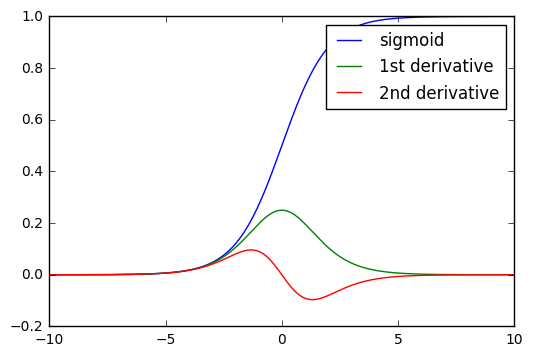

In [119]:
x_lin = np.arange(-10,10.0001,0.001)
print(x_lin)
plt.plot( x_lin, sigmoid(x_lin), label='sigmoid' )
plt.plot( x_lin, firstDerSigmoid(x_lin), label='1st derivative')
plt.plot( x_lin, secondDerSigmoid(x_lin), label='2nd derivative')
plt.legend()

In [324]:
%store -r XX
XX

array([[ 2.19932813, -0.62438891, -0.93533771, ..., -4.28254183,
        -0.20693657, -0.29250463],
       [ 0.58541685, -0.30778086, -0.37663362, ..., -1.18503577,
        -0.15195308, -0.11931674]])

In [436]:
def computeLoss(x,w):
    second_term = np.sum(np.log(firstDerSigmoid(np.dot(w,x))),axis=0)  
    loss = np.log(np.linalg.det(w)) + np.mean(second_term)
    return loss

def computeIndividualLoss(x,w):
    return np.log(np.linalg.det(w)) + np.sum( np.log( firstDerSigmoid(np.dot(w,x)) ) )

def regularGradientLearning(x, w_init, original_data, eta=0.1, epoch=1):
    w = np.copy(w_init)
    
    loss = computeLoss(x,w)
    print("Epoch %d - loss %.5f" % (0, loss))
    norm = []
    for e in range(epoch):

        for i in range(x.shape[1]):
            eta_t = eta / (i+1)
    
            w_inv = np.linalg.inv(w)
        
            w_dot_x = np.dot(w, x[:,i])
            sigs = 1 - 2*sigmoid(w_dot_x)
 
            outer_prod = np.outer(sigs, x[:,i])
            grad = w_inv.T + outer_prod
            w = w + eta_t*grad
            w = w / np.linalg.norm(w)

            if i % 1000 == 0:
                norm.append(np.linalg.norm(grad))

        loss = computeLoss(x,w)
        print("Epoch %d - loss %.5f" % (e+1, loss))
    s_est = np.dot(w,x) 
    computeCorrelation(s_est,original_data, label="S_estimate")
    return w, norm

W_hiro = np.array([[ 0.9297626,0.28035085],[ 0.2388984, 0.28682381]])
w_learnt, norm_reg = regularGradientLearning(X_centered, W_hiro, S.T, epoch=1, eta=0.5)

Epoch 0 - loss -4.87945
Epoch 1 - loss -3.73797
corr(S_estimate0,s0) = 0.82537554
corr(S_estimate0,s1) = 0.56562397
corr(S_estimate1,s0) = 0.77995385
corr(S_estimate1,s1) = 0.62681959


In [448]:
def naturalGradientLearning(x, w_init, original_data, eta=0.1, epoch=1):
    w = np.copy(w_init) / np.linalg.norm(w_init)
    p = x.shape[1]

    for i in range(p):
        w_dot_x = np.dot(w, x[:,i])
        sigs = 1 - 2*sigmoid(w_dot_x)
        dirac = np.eye(2)
        outer_pd = np.outer(sigs, w_dot_x)
        grad = ( np.dot(dirac, w) + np.dot(outer_pd, w))
        w = ( w + grad*eta )
        w = w / np.linalg.norm(w) # without this the algorithm doesn't work
        
    s_est = np.dot(w,x) 
    computeCorrelation(s_est,original_data, label="S_estimate")
    return w
w_nat = naturalGradientLearning(X_centered, W_hiro, S.T, epoch=1, eta=0.1)

corr(S_estimate0,s0) = 0.99736466
corr(S_estimate0,s1) = 0.07380867
corr(S_estimate1,s0) = -0.03865981
corr(S_estimate1,s1) = 0.99920291


In [449]:
s_x_est_w_init = np.dot(W_hiro,X_centered) 
computeCorrelation(s_x_est_w_init,S.T, label="X")

corr(X0,s0) = 0.81550475
corr(X0,s1) = 0.57977778
corr(X1,s0) = 0.80482207
corr(X1,s1) = 0.59453009


In [243]:
s_x_est = np.dot(w_learnt,X_centered) 
computeCorrelation(s_x_est,S.T, label="X")

corr(X0,s0) = 0.95518246
corr(X0,s1) = 0.29722135
corr(X1,s0) = 0.78271435
corr(X1,s1) = 0.62336714


In [439]:
s_x_est_nat = np.dot(w_nat,X_centered) 
computeCorrelation(s_x_est_nat,S.T, label="X")

corr(X0,s0) = 0.99995370
corr(X0,s1) = -0.00836192
corr(X1,s0) = 0.00546802
corr(X1,s1) = 0.99999115


In [199]:
computeCorrelation(X_centered,S.T, label="X_centered")

corr(X_centered0,s0) = 0.82303599
corr(X_centered0,s1) = 0.56902613
corr(X_centered1,s0) = 0.78833919
corr(X_centered1,s1) = 0.61623400


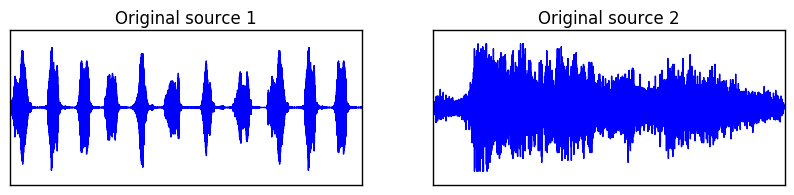

In [201]:
def plotSignal(x, prefix):
    total = x.shape[1]
    x_range = np.array(range(total))
    
    plt.figure(figsize=(10,2))
    for i in range(x.shape[0]):
        plt.subplot(1,2,i+1)
        plt.plot(x_range, x[i,:].T)
        plt.title('%s %d' % (prefix, i+1) )
        plt.xticks([])
        plt.yticks([])
        
plotSignal(S.T, prefix="Original source")

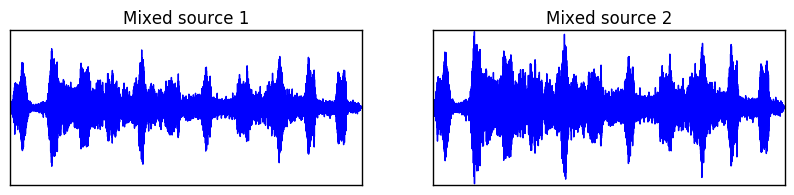

In [202]:
plotSignal(X_centered, prefix="Mixed source")

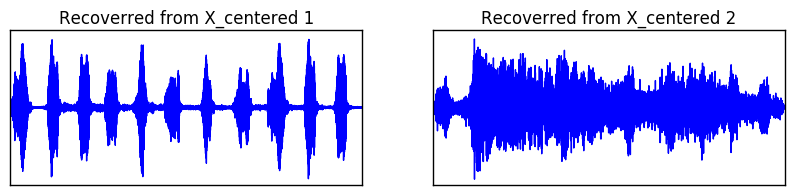

In [228]:
plotSignal(s_x_est, prefix="Recoverred from X_centered")

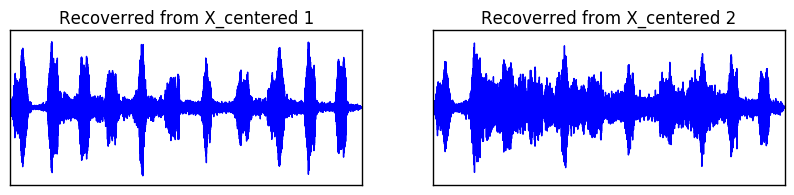

In [203]:
plotSignal(s_x_est, prefix="Recoverred from X_centered")

In [190]:
X_centered - s_x_est

array([[-0.00034158, -0.00034524, -0.00043245, ..., -0.00026856,
        -0.00053067, -0.00034158],
       [ 0.00116337,  0.00117568,  0.00146915, ...,  0.00086121,
         0.00183491,  0.00116337]])

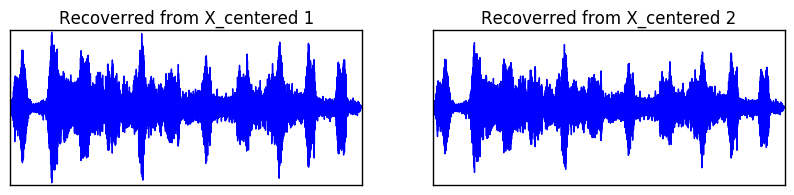

In [187]:

plotSignal(X_permuted_centered, prefix="Mixed source (permutatd)")

In [239]:
invW= np.linalg.solve(W_init,np.eye(2))

In [440]:
from scipy.io.wavfile import write
write('test0.wav', 8192, S[:,0])
write('test1.wav', 8192, S[:,1])

write('x_centered0.wav', 8192, X_centered[0,:])
write('x_centered1.wav', 8192, X_centered[1,:])

write('x_permuted_centered0.wav', 8192, X_permuted_centered[0,:])
write('x_permuted_centered1.wav', 8192, X_permuted_centered[1,:])

write('s_estimate0.wav', 8192, s_x_est[0,:])
write('s_estimate1.wav', 8192, s_x_est[1,:])

write('s_estimate_inv0.wav', 8192, s_x_est_w_init[0,:])
write('s_estimate_inv1.wav', 8192, s_x_est_w_init[1,:])

write('s_estimate_nat0.wav', 8192, s_x_est_nat[0,:])
write('s_estimate_nat1.wav', 8192, s_x_est_nat[1,:])

In [181]:
S[:,1].shape

(18000,)

In [105]:
w_res

array([[ 2.06591356, -0.70919898],
       [ 0.33842817,  2.2279143 ]])

In [ ]:
def regularGradientLearning(x, w_input, original_source, eta=0.1, no_epoch = 10):    
    print("Epoch 0 - loss %.5f" % (computeLoss(x,w_input)))
    grad = np.zeros((2,2))

    for e in range(no_epoch):
        
        w_inv = np.linalg.inv(w_input)

        for i in range(x.shape[1]):
            eta_t = eta / (i+1)
            
            l_1 = computeIndividualLoss(x[:,i],w_input)
    
            d  = np.dot(w_input, x[:,i])

            second_der  = secondDerSigmoid(d)
            first_der   = firstDerSigmoid(d)
            res = second_der / first_der
            
            od = np.outer(res, x[:,i].T)

            grad  = grad + od

            
    
            l_2 = computeIndividualLoss(x[:,i],w_input)
            if i % 1000 == 0 :
                print(grad)
#                 print(w_inv)
                print("Individual Lost for %i | before %f after %f (diff %f)" % (i, l_1, l_2, l_2-l_1))
        w_input     = w_input + eta*grad / x.shape[0]
        loss = computeLoss(x,w_input)
        print("Epoch %d - loss %.5f" % (e+1, loss))

    s_est = np.dot(w_input,x) 
    computeCorrelation(s_est,original_source, label="S_estimate")
    return w_input
w_res = regularGradientLearning(X_centered, W_init, S.T, no_epoch=1, eta=0.01)